In [4]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cPickle as cpkl



In [71]:
ntopics = 5

#due to size constraints we load the stan results where the samples have been averaged out (file with samples >200mb)
with open('stan_results.cpkl','r') as f:
    stan_data = cpkl.load(f)
    
with open('preprocessed_data.cpkl','r') as f:
    data = cpkl.load(f)
    
genes = data['genes']
t_train = data['t_train']
x_train = data['x_train']
words = data['words']
sampleid = data['sampleid']
    
theta_uni = stan_data['theta_uni']
phi_uni = stan_data['phi_uni']

theta_infor = stan_data['theta_infor']
phi_infor = stan_data['phi_infor']


## STAN Results

We fitted two different LDA models using stan.
 * Uniform prior: This models used a flat prior on the word distribution (alpha)
 * Informative prior: This models used a the background count frequencies as the prior for the count distribution (alpha)

#### Convergenve statistics

Due to long runtime the stan simulation was performed with 2000 samples and 4 chains. Below is seen a table of the convergene MCMC convergence statistics. (values on parenthesis af STD variation). The results suggests that

 * a) The effective number of samples (n_eff) is low and highly variable suggesting poor convergence
 * b) Rhat is relative high (not close to 1.0) suggeesting that more chains could be beneficial

| Parameter                   | N_eff   | Rhat   | 
|--------|----:|----:|
|Theta - Uniform prior        |44.2 (91.1) |1.5 |
|Phi - Uniform prior        |43.82 (152.8) |1.5 |
|Theta - informative prior     |21.1 (24.9) |1.5 |
|Phi - informative prior     |23.7 (87.9)  |1.5 |

Overall the STAN convergene statistics show that the models are not completely converged why the results might be misleading



In [ ]:
#STAN models (The models where run on servers due to high runtime (>10 hours))
LDA_model = """

data {
  int<lower=2> K;               // num topics
  int<lower=2> V;               // num words
  int<lower=1> M;               // num docs
  int<lower=1> N;               // total word instances
  int<lower=1,upper=V> w[N];    // word n
  int<lower=1,upper=M> doc[N];  // doc ID for word n
  vector<lower=0>[K] alpha;     // topic prior
  vector<lower=0>[V] beta;      // word prior
}
parameters {
  simplex[K] theta[M];   // topic dist for doc m
  simplex[V] phi[K];     // word dist for topic k
}
model {
  for (m in 1:M)  
    theta[m] ~ dirichlet(alpha);  // prior
  for (k in 1:K)  
    phi[k] ~ dirichlet(beta);     // prior
  for (n in 1:N) {
    real gamma[K];
    for (k in 1:K) 
      gamma[k] <- log(theta[doc[n],k]) + log(phi[k,w[n]]);
    increment_log_prob(log_sum_exp(gamma));  // likelihood
  }
}
"""



#### STAN LDA topics

Below are seen heatmaps of the estimated expression for the five fitted topics of the STAN models. We see that

 * 1) The expression of a few genes seems to dominate the topics (noteably Hbb-b1).
 * 2) The topics appear relatively similar which suggests that the structure of the data have not been well captured

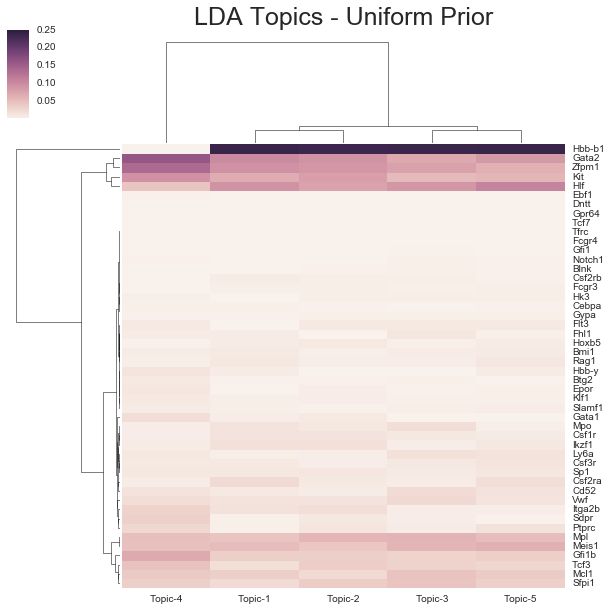

In [69]:
data = pd.DataFrame(data=phi_uni.T,index=genes, columns=['Topic-1','Topic-2','Topic-3','Topic-4','Topic-5'])
cg = sns.clustermap(data,vmax=0.25,metric='euclidean',col_cluster=True,row_cluster=True)
out = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cg.ax_col_dendrogram.set_title('LDA Topics - Uniform Prior',size=25)

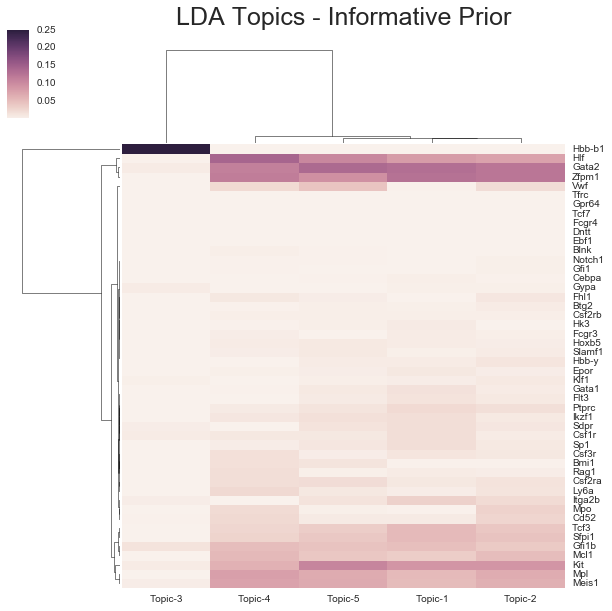

In [70]:
data = pd.DataFrame(data=phi_infor.T,index=genes, columns=['Topic-1','Topic-2','Topic-3','Topic-4','Topic-5'])
cg = sns.clustermap(data,vmax=0.25,metric='euclidean',col_cluster=True,row_cluster=True)
out = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cg.ax_col_dendrogram.set_title('LDA Topics - Informative Prior',size=25)